# Cholesky QR-based retraction 
### Test and compare with the Polar-based retraction on the generalized Stiefel manifold in terms of computational time and accuracy.

#### 1. Set-Up the Generalized Stiefel Manifold


Created with a randomly generated symmetric positive definite matrix G and random points X on the manifold.

In [7]:
import numpy as np
from scipy.linalg import cholesky, qr

def generate_spd_matrix(n: int) -> np.ndarray:
    """
    Function to generate a random symmetric positive definite matrix G of size n x n

    Parameters
    ----------
    n : int
        Size of the matrix

    Returns
    -------
    np.ndarray
        Random symmetric positive definite matrix of size n x n
    """
    G0 = np.random.randn(n, n)
    G = G0.T @ G0
    return G

def generate_random_point_on_stiefel(n: int, p: int) -> np.ndarray:
    """
    Function to generate a random point X on StG(p, n)

    Parameters
    ----------
    n : int
        Number of rows of the matrix
    p : int
        Number of columns of the matrix
    
    Returns
    -------
    np.ndarray
        Random point X on StG(p, n)
    """
    X, _ = qr(np.random.randn(n, p), mode='economic')  # QR decomposition gives a random point
    return X

def generate_random_tangent_vector(X: np.ndarray, G: np.ndarray) -> np.ndarray:
    """
    Function to generate a random tangent vector at X on StG(p, n)

    Parameters
    ----------
    X : np.ndarray
        Point on StG(p, n)
    G : np.ndarray
        Symmetric positive definite matrix of size n x n
    
    Returns
    -------
    np.ndarray
        Random tangent vector at X
    """
    n, p = X.shape
    random_matrix = np.random.randn(n, p)
    tangent_vector = random_matrix - X @ (X.T @ G @ random_matrix)  # Tangent vector at X
    return tangent_vector


#### 2. Implement the Colesky QR-based retraction

In [8]:
def cholesky_qr_retraction(X: np.ndarray, G: np.ndarray, xi: np.ndarray) -> np.ndarray:
    """
    Function to compute the retraction of a tangent vector xi at X on StG(p, n) using Cholesky-QR retraction

    Parameters
    ----------
    X : np.ndarray
        Point on StG(p, n)
    G : np.ndarray
        Symmetric positive definite matrix of size n x n
    xi : np.ndarray
        Tangent vector at X

    Returns
    -------
    np.ndarray
        Retracted point on StG(p, n)
    """
    Z = (X + xi).T @ G @ (X + xi)  # Z = (X + xi)^T G (X + xi)
    L = cholesky(Z)  # Cholesky factorization Z = LL^T
    retracted_point = (X + xi) @ np.linalg.inv(L.T)  # X_next = (X + xi) L^(-T)
    return retracted_point


#### 3. Implement the Polar-based Retraction

In [9]:
from scipy.linalg import polar

def polar_retraction(X: np.ndarray, G: np.ndarray, xi: np.ndarray) -> np.ndarray:
    """
    Function to compute the retraction of a tangent vector xi at X on StG(p, n) using Polar retraction

    Parameters
    ----------
    X : np.ndarray
        Point on StG(p, n)
    G : np.ndarray
        Symmetric positive definite matrix of size n x n
    xi : np.ndarray
        Tangent vector at X
    
    Returns
    -------
    np.ndarray
        Retracted point on StG(p, n)
    """
    Z = (X + xi).T @ G @ (X + xi)  # Z = (X + xi)^T G (X + xi)
    U, _ = polar(Z)  # Polar decomposition of Z
    retracted_point = (X + xi) @ np.linalg.inv(U.T)  # Retract using U (polar factor)
    return retracted_point


#### 4. Test and compare

In [10]:
import time
import logging

import json
import time

def write_to_file(filename: str, data: dict):
    """
    Function to write the data to a file

    Parameters
    ----------
    filename : str
        Name of the file
    data : dict
        Data to be written to the file
    """
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)  # Save the data as JSON for readability

def test_retraction_performance(n: int, p_values: list):
    """
    Function to test the performance of Cholesky QR-based retraction and Polar-based retraction

    Parameters
    ----------
    n : int
        Number of rows of the matrix
    p_values : list
        List of number of columns of the matri
    
    Returns
    -------
    None
    """
    G = generate_spd_matrix(n)
    results = {}  # Store all results in memory

    for p in p_values:
        print(f"Testing for n = {n}, p = {p}")
        X = generate_random_point_on_stiefel(n, p)
        xi = generate_random_tangent_vector(X, G)

        start_time = time.time()
        X_chol = cholesky_qr_retraction(X, G, xi)
        chol_time = time.time() - start_time

        start_time = time.time()
        X_polar = polar_retraction(X, G, xi)
        polar_time = time.time() - start_time

        # Check orthogonality constraints X^T G X = I_p
        chol_accuracy = np.linalg.norm(X_chol.T @ G @ X_chol - np.eye(p))
        polar_accuracy = np.linalg.norm(X_polar.T @ G @ X_polar - np.eye(p))

        # Save the results for this iteration
        results[f"n={n}, p={p}"] = {
            "Cholesky QR-based retraction": {"Time": chol_time, "Accuracy": chol_accuracy},
            "Polar-based retraction": {"Time": polar_time, "Accuracy": polar_accuracy}
        }
        print(f"Cholesky QR-based retraction: Time = {chol_time:.4f}s, Accuracy = {chol_accuracy:.2e}")
        print(f"Polar-based retraction: Time = {polar_time:.4f}s, Accuracy = {polar_accuracy:.2e}\n")

    write_to_file(f"results.json", results)


    
    


In [26]:
import matplotlib.pyplot as plt

def plot_retraction_performance():
    """ 
    Function to plot the performance of Cholesky QR-based retraction and Polar-based retraction
    """
    with open("results.json", 'r') as file:
        results = json.load(file)
    
    p_values = []
    chol_times = []
    polar_times = []
    chol_accuracies = []
    polar_accuracies = []

    for key, result in results.items():
        p = int(key.split(", p=")[1])
        p_values.append(p)
        chol_times.append(result["Cholesky QR-based retraction"]["Time"])
        polar_times.append(result["Polar-based retraction"]["Time"])
        chol_accuracies.append(result["Cholesky QR-based retraction"]["Accuracy"])
        polar_accuracies.append(result["Polar-based retraction"]["Time"])
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(p_values, chol_times, 'o-', label="Cholesky QR-based retraction", color = 'lightpink')
    plt.plot(p_values, polar_times, 'o-', label="Polar-based retraction", color = 'lightblue')
    plt.xlabel("p")
    plt.ylabel("Time (s)")
    plt.title("Performance of Retraction Methods", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid()
    plt.show()


In [12]:
n = 10000  # Large value for n
p_values = [100, 200, 500, 1000, 2000]  # Different values for p
test_retraction_performance(n, p_values)


Testing for n = 10000, p = 100
Cholesky QR-based retraction: Time = 0.3380s, Accuracy = 2.21e+06
Polar-based retraction: Time = 0.3417s, Accuracy = 2.94e+15

Testing for n = 10000, p = 200
Cholesky QR-based retraction: Time = 0.6105s, Accuracy = 1.84e+06
Polar-based retraction: Time = 0.8846s, Accuracy = 8.48e+15

Testing for n = 10000, p = 500
Cholesky QR-based retraction: Time = 1.5443s, Accuracy = 1.92e+05
Polar-based retraction: Time = 2.0526s, Accuracy = 3.65e+16

Testing for n = 10000, p = 1000
Cholesky QR-based retraction: Time = 3.3120s, Accuracy = 1.67e+06
Polar-based retraction: Time = 5.4589s, Accuracy = 1.18e+17

Testing for n = 10000, p = 2000
Cholesky QR-based retraction: Time = 8.0414s, Accuracy = 7.61e+07
Polar-based retraction: Time = 14.0886s, Accuracy = 4.12e+17



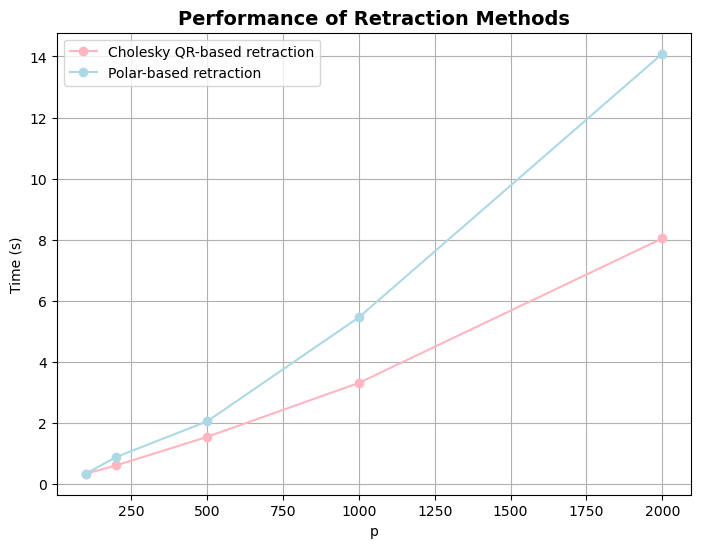

In [27]:
plot_retraction_performance()

In [28]:
# save the plot as png
plt.savefig('retraction_performance.png')

<Figure size 640x480 with 0 Axes>